In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
print ('number of GPUs:', torch.cuda.device_count())

from matplotlib import pyplot as plt 

from minichatgpt.experiments.imdb import config, sent_kwargs
from minichatgpt import Lab, PPOConfig
from minichatgpt.processdata.collators import imdb_dataloader_collator

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




number of GPUs: 2


In [2]:
# For the sake of the speed of this demonstration, the batch_size is temporarily decreased from 256 to 4
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb", # "distilgpt2", #
    learning_rate= 1.41e-5, # 1e-4,
)

#batch_size = 256
#config.batch_size = batch_size
#config.forward_batch_size = batch_size//8

print(config.batch_size)
print(config.forward_batch_size)

sent_kwargs = {
    "return_all_scores": True, # need to do this for output[1]["score"] to be the positive score
    #"top_k":None, # dont do this or the index of the score will not always be positive second
    "function_to_apply": "none",
    "batch_size": config.forward_batch_size
}

256
1


In [3]:
lab = Lab(config)

dataset = lab.build_dataset(dataset_name="imdb",input_min_text_length=2,input_max_text_length=8)

new_policy, old_policy, tokenizer = lab.init_policies_tokenizer()

lab.set_generation_config(do_sample=True,output_min_length=4,output_max_length=16,pad_token_id=tokenizer.eos_token_id)

ppo_trainer = lab.init_ppo_trainer(
    config, 
    new_policy, 
    old_policy, 
    tokenizer, 
    dataset, 
    dataloader_collator = imdb_dataloader_collator,
)

reward_model = lab.init_reward_model()

lab.num_params_million(new_policy)

Found cached dataset imdb (/home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a680d0720b68191d.arrow
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ec21da66149d9ccd.arrow


124.440577

In [4]:
"""

device_map = {
  0: [ 0, 1, 2, 3, 4, 5],
  1: [ 6, 7, 8, 9, 10, 11],
}

new_policy.pretrained_model.parallelize(device_map)
old_policy.pretrained_model.parallelize(device_map)

"""

returns_list = []
rewards_list = []

print(new_policy.pretrained_model.device)
#print(new_policy.v_head)
#new_policy.v_head.summary.to('cuda:1')
print(new_policy.v_head.summary.weight.device)
#lab.reward_model.model.to('cuda:1')
#lab.reward_model.device = torch.device('cuda:1')
print(lab.reward_model.model.device)

rewards_dict = \
lab.reward_model(['great outstanding an fun movie','boring pretentious script'], **sent_kwargs)

cuda:0
cuda:0
cuda:0


/home/carson/Desktop/Projects/minichatgpt/venv/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:107: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


In [5]:
rewards_dict

[[{'label': 'NEGATIVE', 'score': -2.4846694469451904},
  {'label': 'POSITIVE', 'score': 2.7756235599517822}],
 [{'label': 'NEGATIVE', 'score': 2.587322235107422},
  {'label': 'POSITIVE', 'score': -2.987480401992798}]]

In [6]:
config.seed = 0

for batch_step, batch in enumerate(ppo_trainer.dataloader):
    
    queries = batch['input_ids']
    
    #### Get response from gpt2
    responses = []
    for query in queries:
        gen_len = lab.output_length_sampler()
        lab.generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **lab.generation_kwargs)
        responses.append(response.squeeze()[-gen_len:])
        
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in responses]
    
    #### Compute sentiment score
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = lab.reward_model(texts, **sent_kwargs)
    
    scores = [output[1]["score"] for output in pipe_outputs]
    rewards_list.append(np.mean(scores))
    print('reward', rewards_list[-1])
    
    rewards = [torch.tensor(score) for score in scores]
    #rewards = [r.to(new_policy.pretrained_model.device) for r in rewards]
    #rewards = [r.to(new_policy.v_head.summary.weight.device) for r in rewards]
    
    #### Run PPO step 
    stats = ppo_trainer.step(queries, responses, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
    
    returns_list.append(stats['ppo/returns/mean'])
    
    #break

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


reward 0.15907389338553912
reward 0.28290340286912397
reward 0.21686580662208144
reward 0.3638023781204538
reward 0.5357249056614819
reward 0.7791332721653816
reward 1.0574828313556282
reward 1.175240790409589
reward 1.0965642630335424


/home/carson/Desktop/Projects/minichatgpt/venv/lib/python3.7/site-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


reward 1.339720239387134
reward 1.4162519336023252
reward 1.6127304280053067
reward 1.5035379275113883
reward 1.5991757902993413
reward 1.5212992610613583
reward 1.6999627632030752
reward 1.7466414837435877
reward 1.7911719042931509
reward 1.7581519614359422
reward 1.8542564237577608
reward 1.8468316028593108
reward 1.6041478816623567
reward 1.8024272897455376
reward 1.6368593770203006
reward 1.8819131604686845
reward 1.83123739538496
reward 1.9546498791651175
reward 1.8655885235784808
reward 1.8945731800340582
reward 1.7902214944078878
reward 1.7250704804464476
reward 1.8580846980330534


KeyboardInterrupt: 

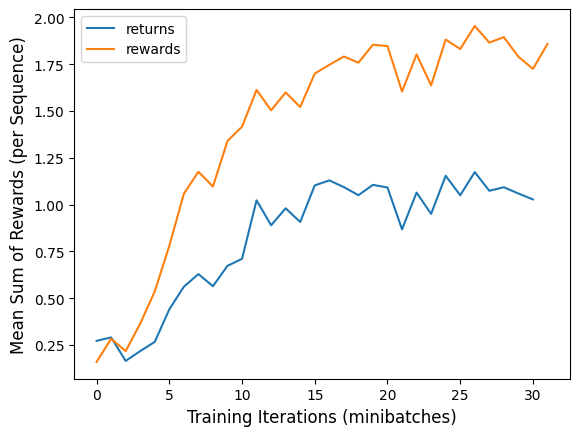

In [9]:
plt.figure()
plt.xlabel('Training Iterations (minibatches)', fontsize=12)
plt.ylabel('Mean Sum of Rewards (per Sequence)', fontsize=12)
plt.plot(returns_list, label='returns')
plt.plot(rewards_list, label='rewards')
plt.legend()
plt.show()

In [7]:
texts[::100]

['This film has gone through another version without a',
 'I thought this was logical. Then I',
 'On Sunday July 27, 1997, while visiting Dudley, a local TV reporter was interviewing dif']

In [8]:
pipe_outputs[::100]

[[{'label': 'NEGATIVE', 'score': 0.4410437047481537},
  {'label': 'POSITIVE', 'score': -0.6981233358383179}],
 [{'label': 'NEGATIVE', 'score': 0.12310316413640976},
  {'label': 'POSITIVE', 'score': -0.176642045378685}],
 [{'label': 'NEGATIVE', 'score': 0.09334967285394669},
  {'label': 'POSITIVE', 'score': -0.22255778312683105}]]